In [ ]:
import cv2
import numpy as np
import os
import subprocess
import glob
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
TEST_IMAGE = "test.jpg"
DEBUG = False

def plot_image(image, title):
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(title)
    plt.show()
    
def save_image(image, title):
    cv2.imwrite(title, image)
    
def grayscale(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if DEBUG:
        plot_image(grayscale_image, "grayscale")
    return grayscale_image

def blur(image):
    blur_image = cv2.GaussianBlur(image, (3,3),0)
    if DEBUG:
        plot_image(blur_image, "blur")
    return blur_image
        
def canny(image):
    canny_image = cv2.Canny(image, 100, 150)
    if DEBUG:
        plot_image(canny_image, "canny")
    return canny_image
        
def roi(image):
    bottom_padding = 100 # Front bumper compensation
    height = image.shape[0]
    width = image.shape[1]
    # FYI, below values are highly dependant on the camera calibration i.e what part of the road is actually being captured
    bottom_left = [0, height]
    bottom_right = [width, height]
    top_right = [width*2/5, height*1/2]
    top_left = [width*2/5, height*1/2]
    
    '''
    bottom_left = [0, height-bottom_padding]
    bottom_right = [width, height-bottom_padding]
    top_right = [width*1/3, height*1/3]
    top_left = [width*2/3, height*1/3]
    '''
    vertices = [np.array([bottom_left, bottom_right, top_left, top_right], dtype=np.int32)]
    mask = np.zeros_like(image)  
    cv2.fillPoly(mask, vertices, 255)
    if DEBUG:
        plot_image(mask, "mask")
    masked_image = cv2.bitwise_and(image, mask)
    if DEBUG:
        plot_image(masked_image, "roi")
    return masked_image
    
def averaged_lines(image, lines):
    right_lines = []
    left_lines = []
    for x1,y1,x2,y2 in lines[:, 0]:
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope >= 0: 
            right_lines.append([slope, intercept])
        else:
            left_lines.append([slope, intercept])
            
    def merge_lines(image, lines):
        if len(lines) > 0:
            slope, intercept = np.average(lines, axis=0)
            y1 = image.shape[0]
            y2 = int(y1*(1/2))
            x1 = int((y1 - intercept)/slope)
            x2 = int((y2 - intercept)/slope)
            return np.array([x1, y1, x2, y2])
        
    left = merge_lines(image, left_lines)
    right = merge_lines(image, right_lines)
    return left, right

def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    lines_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    lines = cv2.HoughLinesP(image, rho, theta, threshold, minLineLength=min_line_len, maxLineGap=max_line_gap) ## np.array([]) delete
    if lines is not None:
        lines = averaged_lines(image, lines)
        for line in lines:
            if line is not None:
                x1,y1,x2,y2 = line
                cv2.line(lines_image, (x1, y1), (x2, y2), (0, 0, 255), 20)
        if DEBUG:
            plot_image(lines_image, "lines")
    return lines_image

def combine_images(image, initial_image, α=0.9, β=1.0, λ=0.0):
    combined_image = cv2.addWeighted(initial_image, α, image, β, λ)
    if DEBUG:
        plot_image(combined_image, "combined")
    return combined_image

def find_street_lanes(image):
    grayscale_image = grayscale(image)
    blur_image = blur(grayscale_image)
    canny_image = canny(blur_image)
    roi_image = roi(canny_image)
    cv2_imshow(roi_image)
    hough_lines_image = hough_lines(roi_image, 0.9, np.pi/180, 60, 90, 30) ## parameter change
    final_image = combine_images(hough_lines_image, image)
    return final_image

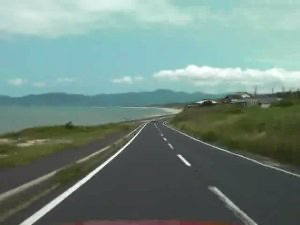

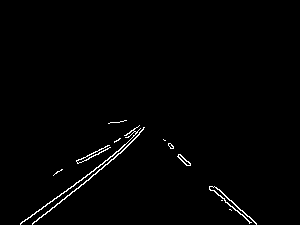

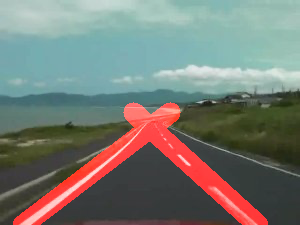

In [ ]:

# Test Image
TEST_IMAGE = "test.jpg"
test_image = cv2.imread(TEST_IMAGE)
cv2_imshow(test_image)
cv2_imshow(find_street_lanes(test_image))


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.jpg to test.jpg
